# Hours of work to pay for a hospital visit.

Data.world's "Makeover Monday" recently used median earnings and Zillow home prices across the USA to determine how many hours per month, a person would have to work to pay their monthly house note.
<br> Given this data, I wanted to also determine how many work hours a trip to the hospital would cost to pay off. 

In [5]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(maps)

Warning message:
"package 'maps' was built under R version 3.4.4"

## First, lets find some medical cost data.
The Kaiser Family Foundation, KFF, has a nice collection of datasets.

Selected health services, expenditures per capita by state from 2014
https://www.kff.org/other/state-indicator/health-spending-per-capita-by-service/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

#### Sped up for loops:
This chunk shows a strategy for getting more speed from R's for loop.
According to Advanced R by Hadley Wickham, for loops operating on data frames can appear slow because data frames are not considered a primitive object. As a result, edits to data frames are not actually made in place but by duplicating and overwrighting the object (a much slower process).
<br>My fix here is to convert the data frame to a primitive object, a list, run the for loop, then convert back to a data frame.

In [6]:
kff_exp_data = read.csv("kff_exp_per_capita_by_service_by_state.csv",
                    stringsAsFactors = FALSE)

names(kff_exp_data) = gsub(pattern = "\\.\\.",
                       replacement = "_",
                       x = names(kff_exp_data)) %>%
  gsub(pattern = "\\.",
       replacement = "_",
       x = .)

### Cleanup data with $ in their string
kff_exp_data = kff_exp_data %>% 
  as.list() 
for(i in 1:length(kff_exp_data)){
  for(j in 1:length(kff_exp_data[[i]])){
    kff_exp_data[[i]][j] = gsub(pattern = "\\$", replacement = "", x = kff_exp_data[[i]][j])
  }
  if(suppressWarnings(!is.na(as.numeric(kff_exp_data[[i]][1])))){
    kff_exp_data[[i]] = kff_exp_data[[i]] %>%
      as.numeric()
  }
}

kff_exp_data = kff_exp_data %>% 
  as.data.frame(stringsAsFactors = FALSE)

kff_exp_data

Location,Hospital_Care,Physician_and_Clinical_Services,Other_Professional_Services,Prescription_Drugs_and_Other_Medical_Nondurables,Nursing_Home_Care,Dental_Services,Home_Health_Care,Medical_Durables,Other_Health_Residential_and_Personal_Care,Timeframe,Title
United States,3079,1874,260,1114,479,354,262,146,475,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Alabama,2625,1739,170,1407,391,279,202,142,324,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Alaska,4715,3368,465,640,204,542,195,139,797,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Arizona,2337,1774,248,814,286,335,136,175,347,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Arkansas,2673,1635,262,1169,440,309,181,104,635,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
California,2753,1983,217,955,383,376,291,97,495,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Colorado,2739,1602,325,681,385,419,192,172,290,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Connecticut,3326,2186,322,1476,854,469,296,141,790,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
Delaware,4078,2259,348,1525,608,409,239,197,591,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation
District of Columbia,5233,2457,223,1171,583,410,653,116,1098,2014,Health Care Expenditures per Capita by Service by State of Residence | The Henry J. Kaiser Family Foundation


## Hospital admission rates
I have costs per state. Now lets extract per capita admission rates.
<br>Hospital admissions per 1000 of population in 2016
https://www.kff.org/other/state-indicator/admissions-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

In [7]:
kff_admissions_data = read.csv("kff_admissions_per_1000_population.csv",
                               stringsAsFactors = FALSE)

names(kff_admissions_data) = gsub(pattern = "\\.\\.",
                       replacement = "_",
                       x = names(kff_admissions_data)) %>%
  gsub(pattern = "\\.",
       replacement = "_",
       x = .)

kff_admissions_data

Location,State_Local_Government,Non_Profit,For_Profit,Total
United States,13,75,16,103
Alabama,64,28,38,130
Alaska,6,48,15,69
Arizona,4,67,19,90
Arkansas,11,84,23,118
California,13,58,13,84
Colorado,11,50,16,77
Connecticut,2,102,1,105
Delaware,N/A,105,0,106
District of Columbia,N/A,153,33,186


This data is interesting by itself.
<br>It appears that on average, an American will get admitted to the hospital every 10 years. 
<br>(103 admissions / 1000 people = 10% chance of admission)


## Kff state populations, 2017
Now I need KFF's assumptions for population to be able to convert the percapita data.
https://www.kff.org/other/state-indicator/total-residents/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

In [8]:
kff_populations_data = read.csv("kff_state_populations.csv",
                               stringsAsFactors = FALSE) %>% 
  select(-Footnotes)

names(kff_populations_data) = gsub(pattern = "\\.\\.",
                       replacement = "_",
                       x = names(kff_populations_data)) %>%
  gsub(pattern = "\\.",
       replacement = "_",
       x = .)

kff_populations_data

Location,Total_Residents
United States,317022500
Alabama,4741400
Alaska,710100
Arizona,6841300
Arkansas,2910000
California,38713900
Colorado,5461100
Connecticut,3478700
Delaware,931700
District of Columbia,657600


## Merge kff data together

In [9]:
kff_data = kff_admissions_data %>% 
  select(Location, Total) %>% 
  rename(Total_admissions_per_1000_pop = Total)

kff_data = kff_data %>% 
  left_join(kff_exp_data %>% 
              select(Location, Hospital_Care),
            by = "Location") %>% 
  rename(Hospital_Care_exp_per_capita = Hospital_Care) %>% 
  left_join(kff_populations_data,
            by = "Location")

kff_data = kff_data %>% 
  mutate(Total_admissions = Total_admissions_per_1000_pop / 1000 * Total_Residents,
         Total_Hospital_Care_exp = Hospital_Care_exp_per_capita * Total_Residents) %>%
  select(-Total_admissions_per_1000_pop, -Hospital_Care_exp_per_capita)

kff_data = kff_data %>% 
  mutate(cost_per_hospital_visit = Total_Hospital_Care_exp / Total_admissions) %>% 
  rename(State = Location)

kff_data

Warning message:
"package 'bindrcpp' was built under R version 3.4.3"

State,Total_Residents,Total_admissions,Total_Hospital_Care_exp,cost_per_hospital_visit
United States,317022500,32653317.5,976112277500,29893.20
Alabama,4741400,616382.0,12446175000,20192.31
Alaska,710100,48996.9,3348121500,68333.33
Arizona,6841300,615717.0,15988118100,25966.67
Arkansas,2910000,343380.0,7778430000,22652.54
California,38713900,3251967.6,106579366700,32773.81
Colorado,5461100,420504.7,14957952900,35571.43
Connecticut,3478700,365263.5,11570156200,31676.19
Delaware,931700,98760.2,3799472600,38471.70
District of Columbia,657600,122313.6,3441220800,28134.41


## Now for data.world
Pull in the data from their makeover Monday.
https://data.world/makeovermonday/2018w47
https://howmuch.net/sources/hours-work-afford-home
2015 Incomes
2017(?) Mortage rates and Zillow prices

In [10]:
Hours_to_Pay_Mortgage = read.csv("Hours to Pay Mortgage.csv",
                                 stringsAsFactors = FALSE)

### change ".." and "." to single "_"
names(Hours_to_Pay_Mortgage) = gsub(pattern = "\\.\\.",
                       replacement = "_",
                       x = names(Hours_to_Pay_Mortgage)) %>%
  gsub(pattern = "\\.",
       replacement = "_",
       x = .)

### Make a data fram a list so for loop will run faster
Hours_to_Pay_Mortgage = Hours_to_Pay_Mortgage %>% 
  as.list() 

for(i in 1:length(Hours_to_Pay_Mortgage)){
  for(j in 1:length(Hours_to_Pay_Mortgage[[i]])){
    Hours_to_Pay_Mortgage[[i]][j] = 
      gsub(pattern = ",", replacement = "", x = Hours_to_Pay_Mortgage[[i]][j])
    Hours_to_Pay_Mortgage[[i]][j] = 
      gsub(pattern = "%", replacement = "", x = Hours_to_Pay_Mortgage[[i]][j])
  }
  if(suppressWarnings(!is.na(as.numeric(Hours_to_Pay_Mortgage[[i]][1])))){
    Hours_to_Pay_Mortgage[[i]] = Hours_to_Pay_Mortgage[[i]] %>%
      as.numeric()
  }
}

Hours_to_Pay_Mortgage = Hours_to_Pay_Mortgage %>% 
  as.data.frame(stringsAsFactors = FALSE)

### Remove columns
Hours_to_Pay_Mortgage = Hours_to_Pay_Mortgage %>% 
  select(-Median_Home_Listing_Price,
         -X30_year_Fixed_Mortgage_Rate,
         -Median_Household_Income,
         -Number_of_Periods,
         -Present_Value)

Hours_to_Pay_Mortgage

City,State,Monthly_Mortgage_Payment,Hours_per_Month_to_Afford_a_Home
Toledo,Ohio,273,16.9
Memphis,Tennessee,321,18.4
Cleveland,Ohio,255,20.3
Buffalo,New York,327,21.4
Baltimore,Maryland,504,24.9
Wichita,Kansas,558,25.3
Fort Wayne,Indiana,543,25.9
Milwaukee,Wisconsin,452,26.2
Indianapolis,Indiana,529,26.3
Columbus,Ohio,597,27.3


### Oh no! The data is supposed to be by state, but it's by city.
#### I need to aggregate it to the state level using weighted averages by city population.

## City population data
https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk

In [14]:
city_pop_1 = read.csv("PEP_2017_PEPANNRSIP.US12A.csv",
                      stringsAsFactors = FALSE) %>% 
  janitor::remove_empty("cols")

### change ".." and "." to single "_"
names(city_pop_1) = gsub(pattern = "\\.\\.",
                       replacement = "_",
                       x = names(city_pop_1)) %>%
  gsub(pattern = "\\.",
       replacement = "_",
       x = .)

### Remove first label columns
city_pop_1 = city_pop_1 %>% 
  select(names(city_pop_1) %>% 
           .[1:6] %>% 
            one_of() %>% 
           -.)

names(city_pop_1)[1] = "location"

names(city_pop_1) = city_pop_1 %>% 
  names() %>% 
  gsub(pattern = "res", replacement = "", x = .) %>% 
  gsub(pattern = "pop", replacement = "", x = .)

### Remove Columns from year 2010 with other data sources 
city_pop_1 = city_pop_1[,which(nchar(names(city_pop_1)) <= nchar("location"))]

### clean up location column into city & state
city_pop_1 = city_pop_1 %>% 
  mutate(city_pos = regexpr(text = location, pattern = ", ")) %>% 
  mutate(City = substr(x = location, start = 1, stop = city_pos - 1),
         State = substr(x = location, 
                        start = city_pos + nchar(", "), stop = nchar(location))) %>% 
  select(-location, -city_pos) %>% 
  select(State, City, everything()) 

### Correct "Saint Paul" to "St. Paul"
city_pop_1 = city_pop_1 %>% 
  mutate(City = ifelse(State == "Minnesota", 
                       ifelse(grepl("St. Paul", City),
                              "Saint Paul",
                              City),
                       City))

names(city_pop_1) = gsub(pattern = "7", replacement = "", x = names(city_pop_1))

### gather the years
city_pop_1 = city_pop_1 %>%
  #select(-state, -city) %>%
  gather(key = year, value = population, -2:-1) %>%
  filter(year == max(year)) %>%
  select(-year) %>% ### drop 2016
  arrange(State, City)

city_pop_1

State,City,population
Alabama,Auburn city,62703
Alabama,Birmingham city,211263
Alabama,Decatur city,54605
Alabama,Dothan city,68172
Alabama,Hoover city,84551
Alabama,Huntsville city,191956
Alabama,Mobile city,191590
Alabama,Montgomery city,200066
Alabama,Tuscaloosa city,98767
Alaska,Anchorage municipality,297376


## Join city populations data into mortgage

In [15]:
Hours_to_Pay_Mortgage = Hours_to_Pay_Mortgage %>% 
  mutate(city_regex_ind = 1:nrow(Hours_to_Pay_Mortgage))

Hours_to_Pay_Mortgage$city_regex_ind = 
  vapply(1:nrow(Hours_to_Pay_Mortgage),
         FUN.VALUE = numeric(1),
         function(i){
           for(j in 1:nrow(city_pop_1)){
             if(grepl(pattern = Hours_to_Pay_Mortgage$State[i], 
                      x = city_pop_1$State[j]) &
                grepl(pattern = Hours_to_Pay_Mortgage$City[i], 
                      x = city_pop_1$City[j])){
               return(j)
             }
             ### Cause "Winston-Salem" hyphen causing problems
             if(grepl(pattern = Hours_to_Pay_Mortgage$State[i], 
                      x = city_pop_1$State[j]) &
                grepl(pattern = substr(Hours_to_Pay_Mortgage$City[i], 1, 4), 
                      x = substr(city_pop_1$City[j], 1, 4))){
               return(j)
             }
           }
           return(NA)
         })

Hours_to_Pay_Mortgage = Hours_to_Pay_Mortgage %>% 
  mutate(population = city_pop_1$population[Hours_to_Pay_Mortgage$city_regex_ind]) %>% 
  select(-city_regex_ind)

Hours_to_Pay_Mortgage

City,State,Monthly_Mortgage_Payment,Hours_per_Month_to_Afford_a_Home,population
Toledo,Ohio,273,16.9,278606
Memphis,Tennessee,321,18.4,653369
Cleveland,Ohio,255,20.3,387451
Buffalo,New York,327,21.4,258463
Baltimore,Maryland,504,24.9,616958
Wichita,Kansas,558,25.3,390116
Fort Wayne,Indiana,543,25.9,263893
Milwaukee,Wisconsin,452,26.2,597508
Indianapolis,Indiana,529,26.3,857453
Columbus,Ohio,597,27.3,863741


## Get States averages as weighted by city populations

In [16]:
Hours_to_Pay_Mortgage_per_state = Hours_to_Pay_Mortgage %>% 
  group_by(State) %>% 
  summarise(Monthly_Mortgage_Payment = weighted.mean(Monthly_Mortgage_Payment, population),
            Hours_per_Month_to_Afford_a_Home =
              weighted.mean(Hours_per_Month_to_Afford_a_Home, population)) %>% 
  ungroup()

Hours_to_Pay_Mortgage_per_state

State,Monthly_Mortgage_Payment,Hours_per_Month_to_Afford_a_Home
Alaska,1158.0000,30.90000
Arizona,1023.7754,41.24286
California,2230.8587,84.48499
Colorado,1418.5975,55.13413
District of Columbia,2000.0000,58.90000
Florida,866.2029,42.06204
Georgia,1191.0000,52.30000
Hawaii,2293.0000,64.30000
Idaho,982.0000,40.70000
Illinois,1086.0000,46.70000


## Kff summary by state

In [18]:
kff_summary_1 = kff_data %>% 
  select(State, cost_per_hospital_visit) %>% 
  arrange(desc(cost_per_hospital_visit))

kff_summary_1

State,cost_per_hospital_visit
Alaska,68333.33
Vermont,58375.00
Wyoming,57157.14
Montana,41820.22
New Hampshire,40117.02
Idaho,39454.55
Maine,38754.90
Delaware,38471.70
Washington,38148.15
Wisconsin,38065.22


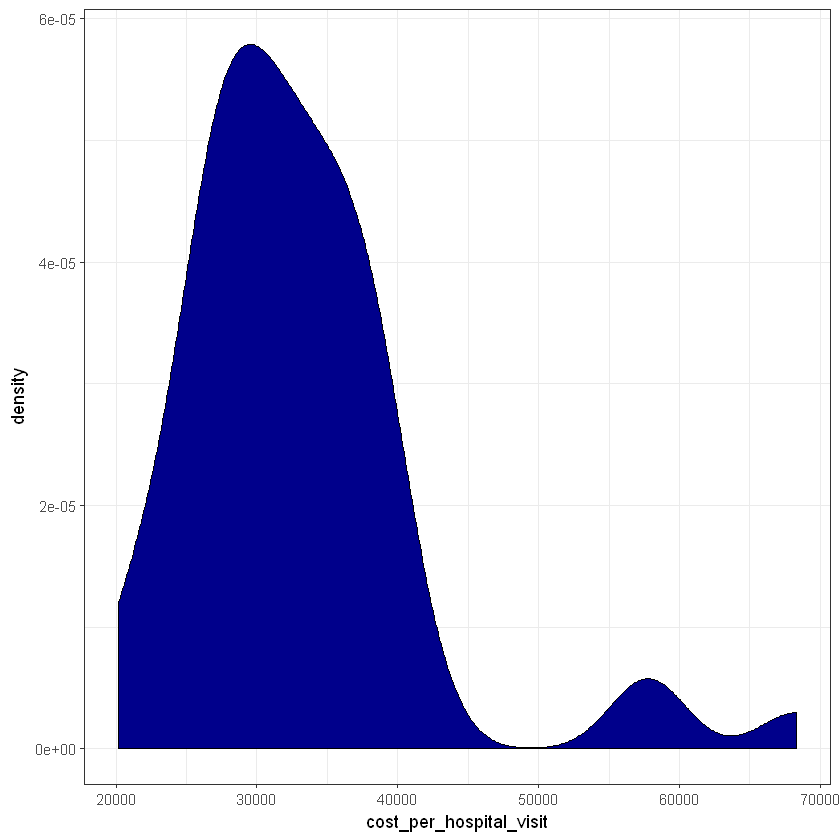

In [19]:
kff_summary_1 %>% 
  ggplot(aes(cost_per_hospital_visit)) +
  geom_density(fill = "dark blue") +
  theme_bw()

## Voila, the answer!
#### Combine mortgage and medical data

In [20]:
Mortgage_and_medical = Hours_to_Pay_Mortgage_per_state %>% 
  left_join(kff_data, by = "State") %>% 
  mutate(years_of_work_to_pay_hospital_visit = cost_per_hospital_visit / Monthly_Mortgage_Payment * Hours_per_Month_to_Afford_a_Home / 40 / 50)

### Sort by years needed
Mortgage_and_medical %>% 
  arrange(desc(years_of_work_to_pay_hospital_visit)) %>% 
  select(State, years_of_work_to_pay_hospital_visit) %>% 
  mutate(Months_equiv = years_of_work_to_pay_hospital_visit * 12)

State,years_of_work_to_pay_hospital_visit,Months_equiv
Wisconsin,0.9238227,11.085873
Alaska,0.9117012,10.940415
Indiana,0.8510777,10.212933
Ohio,0.8441653,10.129984
Maryland,0.8360610,10.032732
New Mexico,0.8256509,9.907810
Idaho,0.8176171,9.811405
Pennsylvania,0.7495680,8.994816
New York,0.7286823,8.744188
Nebraska,0.7237038,8.684446


There are 5 states where the median household would need to work 10 months to afford ne medical visit.
<br>More evidence of health insurance's benefit/necessity.

## Visualize the states
#### Density and cumulative density

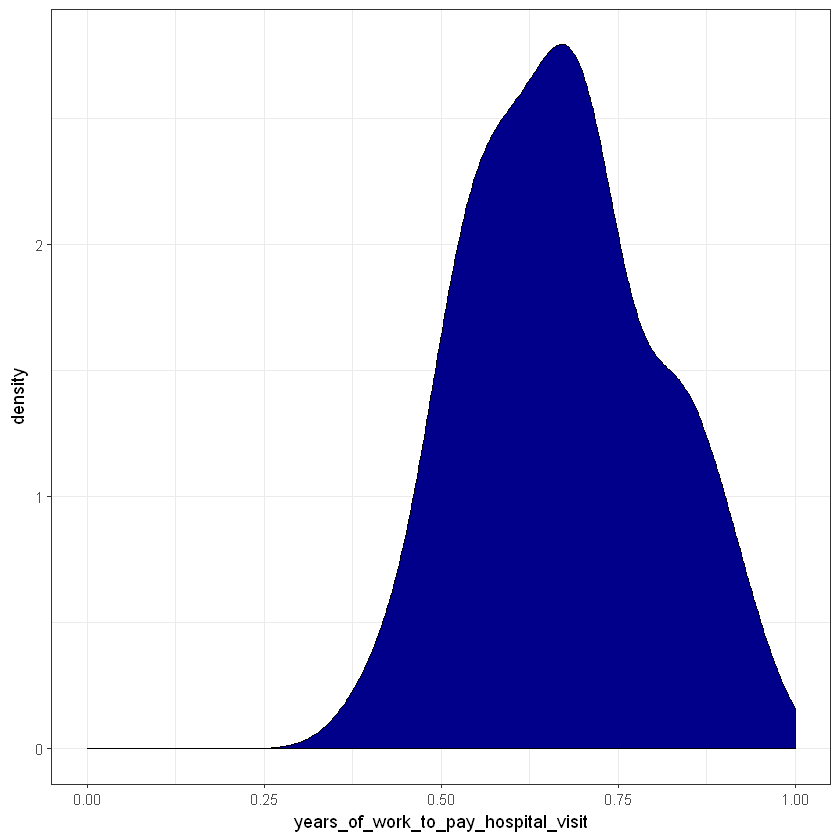

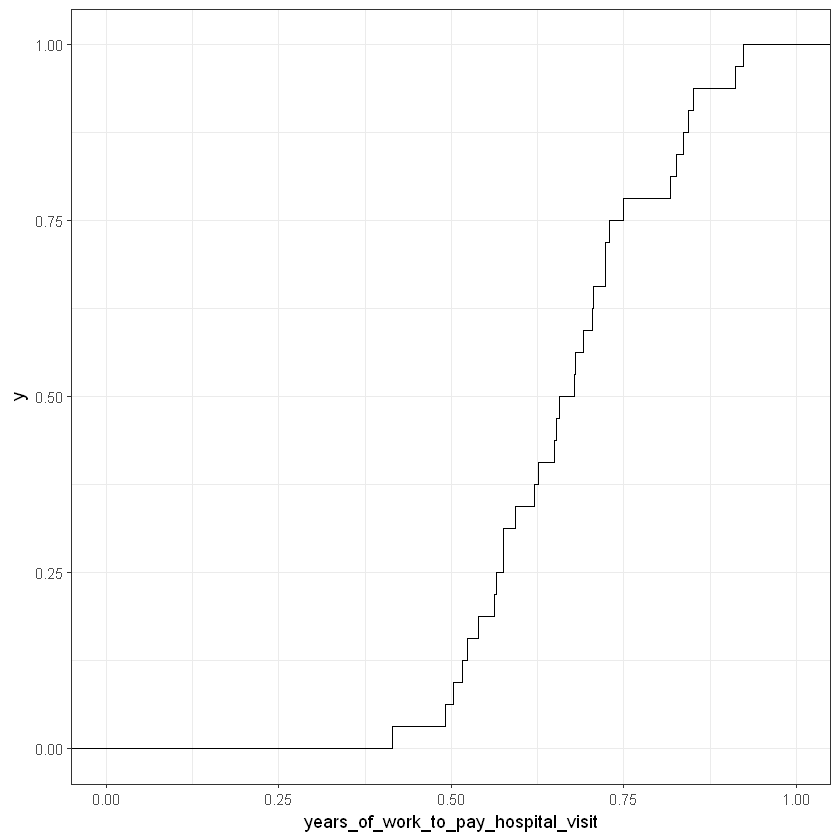

In [21]:
Mortgage_and_medical %>% 
  ggplot(aes(x = years_of_work_to_pay_hospital_visit)) +
  geom_density(fill = "dark blue") +
  theme_bw() +
  xlim(c(0, 1))

Mortgage_and_medical %>% 
  ggplot(aes(x = years_of_work_to_pay_hospital_visit)) +
  geom_step(aes(y=..y..),stat="ecdf") +
  theme_bw() +
  xlim(c(0, 1))

# Using presidential election results, lets compare red/blue states
## load votes data

In [22]:
votes = read.csv("votes_taxes_data_1.csv", stringsAsFactors = FALSE) %>% 
  select(State, DJT_vote_perc_2016, DJT_WIN)

votes

State,DJT_vote_perc_2016,DJT_WIN
Alabama,0.63,1
Alaska,0.53,1
Arizona,0.50,1
Arkansas,0.60,1
Florida,0.49,1
Georgia,0.51,1
Idaho,0.59,1
Indiana,0.57,1
Iowa,0.52,1
Kansas,0.57,1


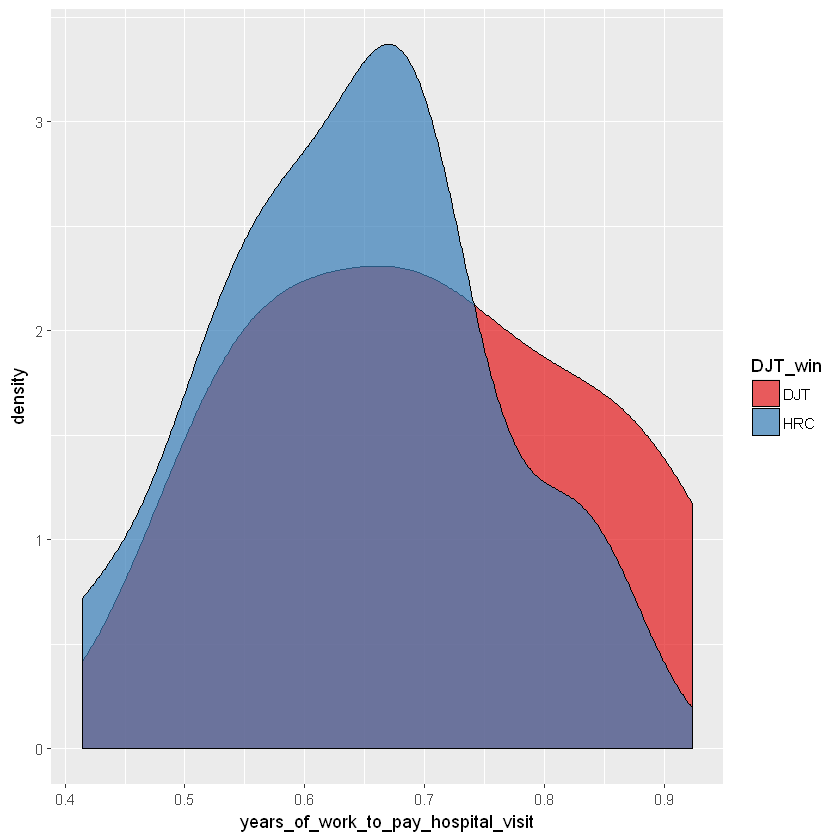

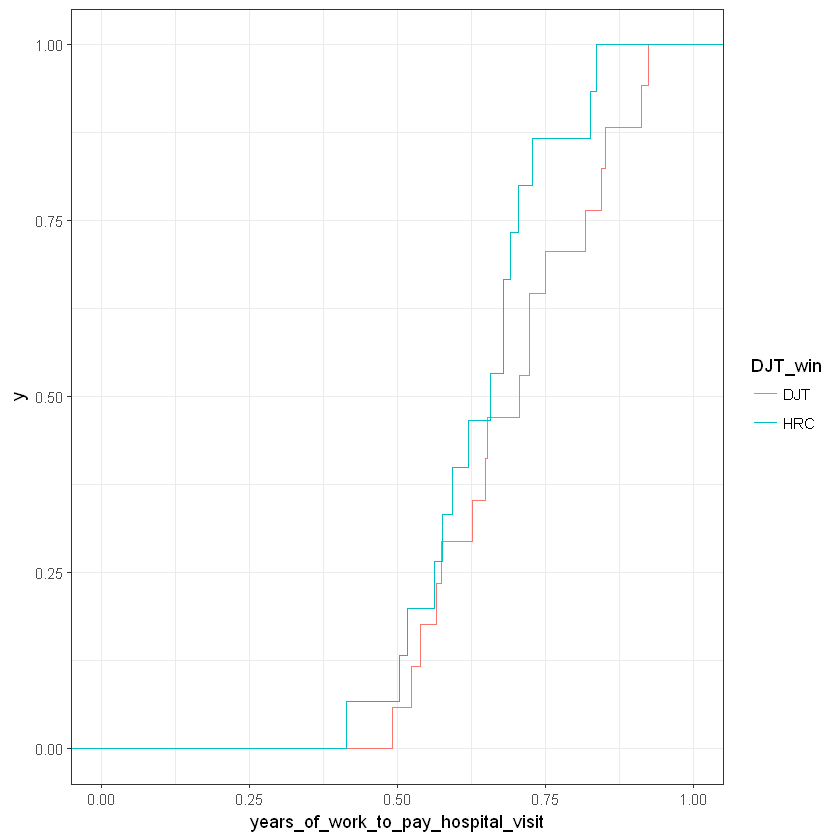

In [23]:
Mortgage_medical_votes = Mortgage_and_medical %>% 
  left_join(votes, by = "State")

Mortgage_medical_votes %>%
  mutate(DJT_win = ifelse(DJT_WIN == 1, "DJT", "HRC")) %>% 
  ggplot(aes(x = years_of_work_to_pay_hospital_visit, fill = DJT_win)) +
  geom_density(alpha = 0.7) +
  scale_fill_brewer(palette = "Set1")

Mortgage_medical_votes %>%
  mutate(DJT_win = ifelse(DJT_WIN == 1, "DJT", "HRC")) %>% 
  ggplot(aes(x = years_of_work_to_pay_hospital_visit, color = DJT_win)) +
  geom_step(aes(y=..y..),stat="ecdf") +
  theme_bw() +
  xlim(c(0, 1))

Are red states more expensive to live in for the sick? 
<br>The data look too close to tell. 

## What about T testing?

In [24]:
which_DJT_win = which(Mortgage_medical_votes$DJT_WIN == 1)
t.test(x = Mortgage_medical_votes$years_of_work_to_pay_hospital_visit[which_DJT_win],
       y = Mortgage_medical_votes$years_of_work_to_pay_hospital_visit[-which_DJT_win],
       alternative = "greater")


	Welch Two Sample t-test

data:  Mortgage_medical_votes$years_of_work_to_pay_hospital_visit[which_DJT_win] and Mortgage_medical_votes$years_of_work_to_pay_hospital_visit[-which_DJT_win]
t = 1.3239, df = 29.959, p-value = 0.09777
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.01671016         Inf
sample estimates:
mean of x mean of y 
0.6984458 0.6392046 


So, given the "crisis of repeatability" circling these days, the frequentist interpretation is also "too close to call". The data meets a 10% threshold

## Heat map the results

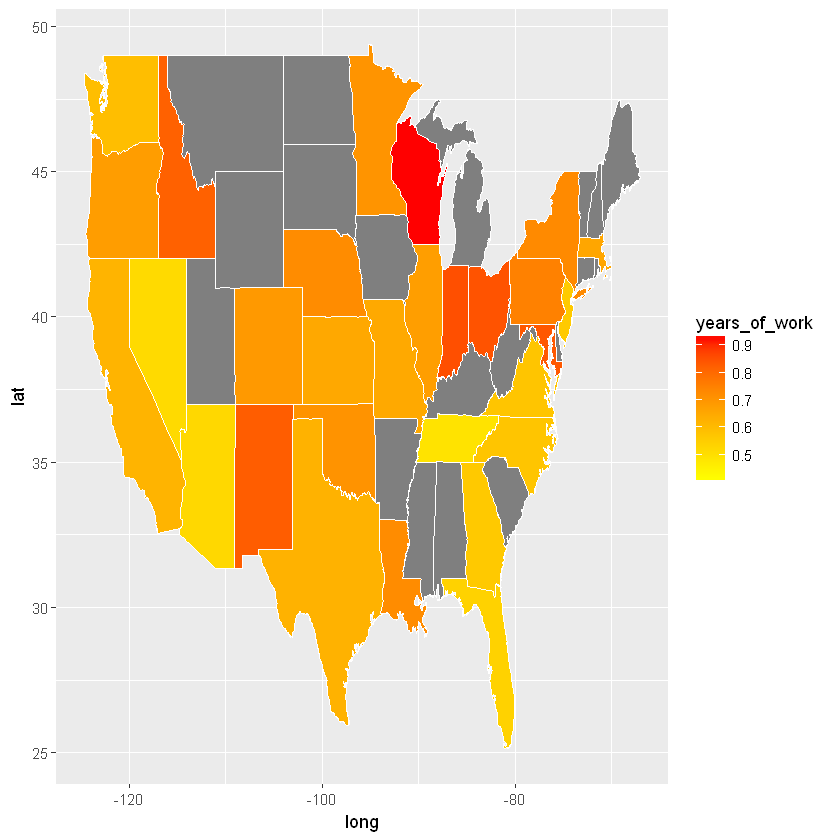

In [25]:
all_states <- map_data("state") %>% 
  left_join(Mortgage_and_medical %>% 
              mutate(state = tolower(State)) %>% 
              select(state, years_of_work_to_pay_hospital_visit),
            by = c("region" = "state")) %>% 
  rename(years_of_work = years_of_work_to_pay_hospital_visit)

### plot all states with ggplot
ggplot() +
  geom_polygon(data=all_states, aes(x=long, y=lat, group = group, 
                                    fill = years_of_work), colour="white") +
  scale_fill_continuous(low = "yellow", high = "red")